# Climpyrical Demo

This notebook shows some basic ways to manipulate CanRCM4 models using `climpyrical` levraging `xarray` and `numpy`.

In [1]:
# performs data IO
from climpyrical.datacube import *
# masking functions
from climpyrical.mask import *
# various grid operations on CanRCM4 model
from climpyrical.gridding import *

## Data I/O Operations

In [2]:
# path to CanRCM4 Model
PATH = '../../climpyrical/tests/data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'

# name of design value as found in the NetCDF4 file
dv = 'snw'

In [3]:
read_data?

Signature: read_data(data_path, design_value_name, keys=None)
Docstring:
Load an ensemble of CanRCM4
models into a single datacube.
------------------------------
Args:
    data_path (Str): path to folder
        containing CanRCM4 ensemble
    design_value_name (str): name of design value exactly as appears
        in the NetCDF4 file
    keys (list, optional): dictionary of required keys in NetCDF4
        file
Returns:
    ds (xarray Dataset): data cube of assembled ensemble models
        into a single variable.
Raises:
    FileNotFoundError: if file not found
    ValueError: if file contains unexpected or invalid data
    KeyError if NetCDF4 file is missing required keys
    TypeError if path provided is invalid
File:      ~/06022020/climpyrical/climpyrical/datacube.py
Type:      function


In [4]:
# read the data
model = read_data(PATH, dv)

model

<xarray.Dataset>
Dimensions:       (level: 35, rlat: 130, rlon: 155)
Coordinates:
    lon           (rlat, rlon) float64 ...
    lat           (rlat, rlon) float64 ...
  * rlon          (rlon) float64 -33.88 -33.44 -33.0 -32.56 ... 33.0 33.44 33.88
  * rlat          (rlat) float64 -28.6 -28.16 -27.72 ... 27.28 27.72 28.16
  * level         (level) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0
Data variables:
    rotated_pole  int32 ...
    snw           (level, rlat, rlon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Wed Sep 11 10:17:05 2019: cdo setmissval,1.00000002004088e+...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...

In [5]:
# Access dataset attributes using xarray
model.rlon.size, model.rlat.size

(155, 130)

In [6]:
# view dataset attributes
model.keys()

KeysView(<xarray.Dataset>
Dimensions:       (level: 35, rlat: 130, rlon: 155)
Coordinates:
    lon           (rlat, rlon) float64 ...
    lat           (rlat, rlon) float64 ...
  * rlon          (rlon) float64 -33.88 -33.44 -33.0 -32.56 ... 33.0 33.44 33.88
  * rlat          (rlat) float64 -28.6 -28.16 -27.72 ... 27.28 27.72 28.16
  * level         (level) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0
Data variables:
    rotated_pole  int32 ...
    snw           (level, rlat, rlon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Wed Sep 11 10:17:05 2019: cdo setmissval,1.00000002004088e+...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...)

# Resizing the CanRCM4 Model

In [7]:
# re-grid the dataset into any new resolution (non-interpolated)
N = 3
model_regridded = regrid_ensemble(model, dv, N)
model_regridded.rlon.size, model_regridded.rlat.size

(465, 390)

In [8]:
N = 5
model_regridded = regrid_ensemble(model, dv, N)
model_regridded.rlon.size, model_regridded.rlat.size

(775, 650)

In [9]:
# display a CanRCM initialization if 3D
import matplotlib.pyplot as plt
# choose first initialization
plt.imshow(model[dv][0, ...], origin='lower')

# Performing Basic Statistics

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


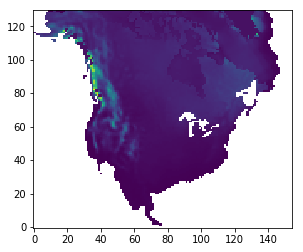

In [10]:
# perform ensemble statistics
import numpy as np
model_median = np.nanmedian(model[dv].values, axis=0)
plt.imshow(model_median, origin='lower')

# Masking

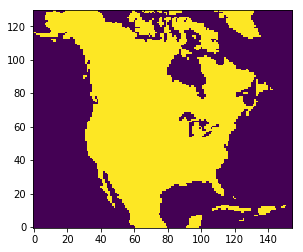

In [11]:
# load mask from file
dvmask = 'sftlf'
mask = read_data('../../climpyrical/tests/data/land_mask_CanRCM4_sftlf.nc', dvmask, keys=['rlat', 'rlon'])

# convert to boolean mask
mask = mask[dvmask][0, ...] > 0.

# display mask
plt.imshow(mask, origin='lower')

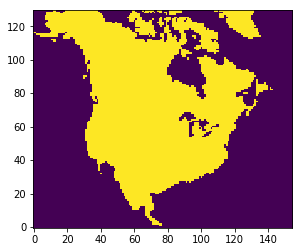

In [12]:
# combine with NaN values found in CanRCM4 model
final_mask = np.logical_and(mask, ~np.isnan(model_median))
plt.imshow(final_mask, origin='lower')

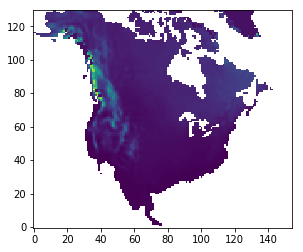

In [13]:
# apply mask and create a masked model
model_median[~final_mask] = np.nan
plt.imshow(model_median, origin='lower')
plt.show()

# Coordinate manipulations

In [14]:
# create paired arrays of coordinate points for every grid cell in model
x, y = flatten_coords(model.rlon.values, model.rlat.values)
x.size, y.size

(20150, 20150)

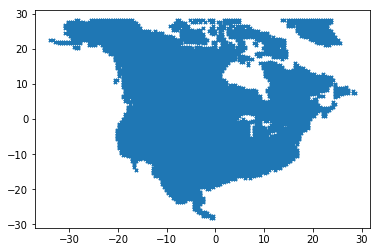

In [15]:
# get coordinate pairs for only the land values
rlon, rlat = np.meshgrid(model.rlon, model.rlat)
plt.scatter(rlon[final_mask], rlat[final_mask], marker='x', s=11)
plt.show()

In [16]:
# coordinate matching
import pandas as pd
# load station data using pandas
df_path = '../../climpyrical/tests/data/sl50_short.csv'
df = pd.read_csv(df_path, index_col=None)
# specify name of design value in csv file
station_dv = 'SL50 (kPa)'

# transform regular coordinates into rotated pole
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)

transform_coords?

Signature:
transform_coords(
    x,
    y,
    source_crs={'init': 'epsg:4326'},
    target_crs={'proj': 'ob_tran', 'o_proj': 'longlat', 'lon_0': -97, 'o_lat_p': 42.5, 'a': 6378137, 'to_meter': 0.0174532925199, 'no_defs': True},
)
Docstring:
Rotates regular WGS84 coordinates to rotated pole
coordinates given a proj4 string that defines
the rotated poles. Projection string parameters are defined
here: https://proj.org/operations/projections/ob_tran.html
Args:
    x,y (numpy.ndarray): array containing
        latitudes and longitudes of
        stations
    source_crs (dict): proj4 dict defining source coordinates
        coordinates used.
Returns:
    x,y (tuple): tuple containing the newly rotated
        coordinates rlon, rlat
Raises:
    TypeError, ValueError in check_transform_coords_inputs
    TypeError:
            If input coords are not numpy arrays
            If crs provided are not dict
    ValueError:
            If x and y are not the same shape
            If x and y range

/home/nannau/06022020/climpyrical/climpyrical/gridding.py:309: UserWarning: 36.222662646628834 is outside of array's domain between -28.59999656677246 and 28.15999984741211.             A station is outside of the CanRCM4 model grid space.
  A station is outside of the CanRCM4 model grid space."
/home/nannau/06022020/climpyrical/climpyrical/gridding.py:309: UserWarning: 32.64541886648805 is outside of array's domain between -28.59999656677246 and 28.15999984741211.             A station is outside of the CanRCM4 model grid space.
  A station is outside of the CanRCM4 model grid space."
/home/nannau/06022020/climpyrical/climpyrical/gridding.py:309: UserWarning: 31.345755932126362 is outside of array's domain between -28.59999656677246 and 28.15999984741211.             A station is outside of the CanRCM4 model grid space.
  A station is outside of the CanRCM4 model grid space."
/home/nannau/06022020/climpyrical/climpyrical/gridding.py:309: UserWarning: 29.59681105435813 is outside of ar

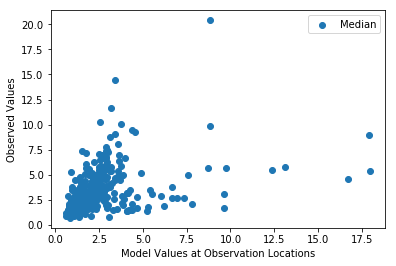

In [17]:
# find nearest grid cell locations in model to station coordinates
ix, iy = find_element_wise_nearest_pos(model.rlon.values, model.rlat.values, rlon_st, rlat_st)

plt.scatter(model_median[iy, ix], df[station_dv], label='Median')
plt.xlabel('Model Values at Observation Locations')
plt.ylabel('Observed Values')
plt.legend()
plt.show()